# Classification Project: Telco Churn

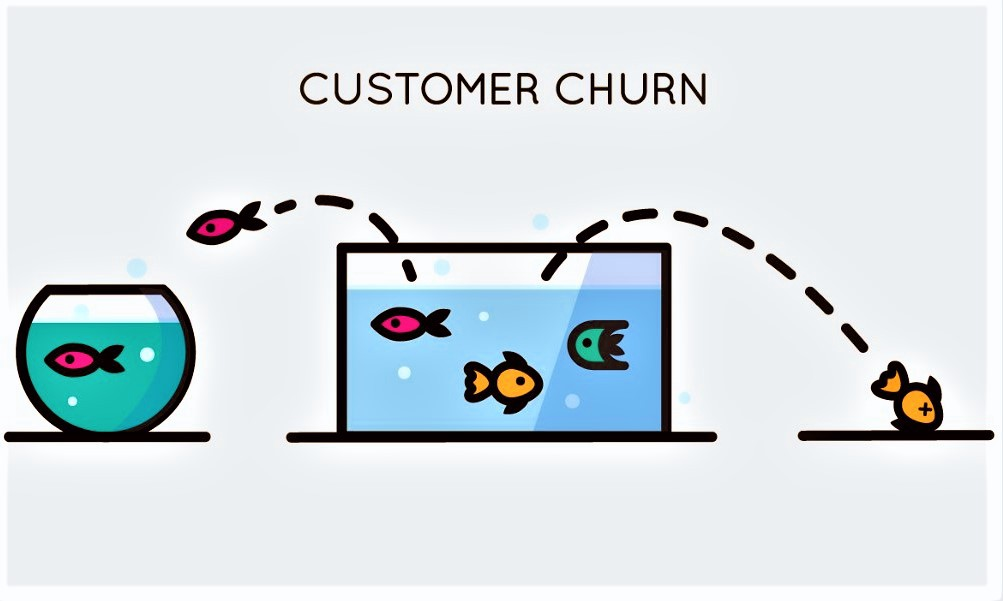

In [1]:
#Data Manipulation
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.stats import chi2_contingency
import os
import warnings
warnings.filterwarnings('ignore')

#Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

#Modeling
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#Custom Imports
from env import host, user, password
import acquire
import prepare

## Project Description:

1. Document code, process (data acquistion, preparation, exploratory data analysis and statistical testing, modeling, and model evaluation), findings, and key takeaways in a Jupyter Notebook Final Report.
2. Create modules (acquire.py, prepare.py) that make my process repeateable and easy to follow.
3. Explore data that will help to understand the drivers of customers churning. Answer questions that arise using charts and statistical tests.
4. Construct a model to predict customer churn using classification techniques, and make predictions for a group of customers.
5. Refine work and processes into a Final Report that shows what work was done, my goals, what I found and my conclusions.

# Acquire Data

**Data located in the CodeUp DB Server 'telco_churn' database**

Data was first SQL queried through MySQLWorkBench.

In [2]:
# Bring in unedited Telco Data
df = acquire.get_telco_data()

### Takeways:
1. Total charges column is coming up as an object, it will need to be changed in the prepare step.
2. There are many columns that are in binary form, which means they need to be translated.
3. No obvious null values.

# Prepare Data

### In this step, I filtered the data to my liking:
1. Drop any and all null values.
2. Convert the total charges column to a float value. 
3. Changed all columns that were binary to numeric.
    - For example, columns that were either 'Yes/No to 1/0.
4. Stored non-binary data in a 'dummies dataframe'.
5. Added the dummies dataframe to the original.
6. Assigned more readable names to columns that needed it.
7. Dropped duplicate columns.
    - all '_id' categories (all of these are covered in different columns that can be encoded)
8. Split the data into the 3 needed dataframes: train, validate, and test.
    - We stratify on 'churn' since this is our main target.

In [3]:
# Function to receive edited Telco data
train, validate, test = prepare.prep_telco_data(df)

# Explore

### After encoding the churn into numeric values, it becomes easy to see the impact it has on customers. Although there may be a lot of reasons as to why, I have focused in on what I believe are the biggest factors associated with churn.

## Initial hypothesis: Churn is most directly associated with 4 factors: Senior citizens, electronic checks, fiber optic internet, and tech support.

Text(0.5, 0, 'Churned')

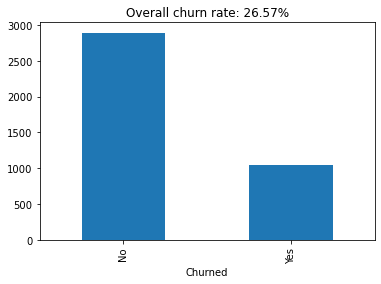

In [4]:
train.churn.value_counts().sort_index().plot.bar()
churn_rate = train.churn_encoded.mean()
plt.title(f"Overall churn rate: {churn_rate:.2%}")
plt.xlabel('Churned')

# Question: Is churn associated with senior citizens?

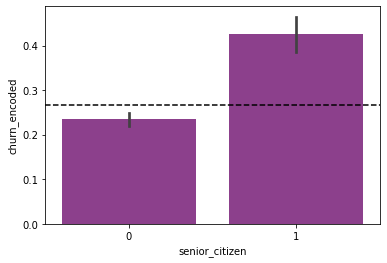

In [21]:
plt.figure(figsize=(6,4))
sns.barplot(x = 'senior_citizen', y = 'churn_encoded', data=train, alpha=.8, color='purple')
plt.axhline(train['churn_encoded'].mean(), ls='--', color='black')
plt.show()

## Takeway: There is very high churn among senior citizens compare to non seniors.

 ### Hypothesis:
H0: Rate of churn is not dependent on being a senior citizen.

H1: Rate of churn is dependent on being a senior citizen.

In [29]:
# set alpha to standard 
alpha = .05

In [31]:
observed1 = pd.crosstab(train.senior_citizen, train.churn)

# scipy function calculates values based on the crosstab created
chi2, p, degf, expected = chi2_contingency(observed1)

print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

if p < alpha:
    print('\nP is less than alpha. We reject the null hypothesis.')

chi^2 = 99.7192
p     = 0.0000

P is less than alpha. We reject the null hypothesis.


### Therefore, being a senior citizen is not independent of churn.

# Question: Is churn associated with fiber optic internet?

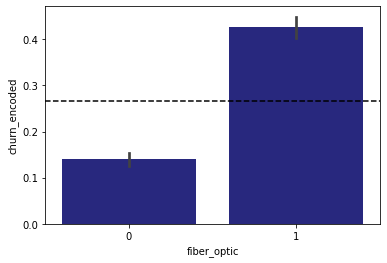

In [20]:
plt.figure(figsize=(6,4))
sns.barplot(x = 'fiber_optic', y = 'churn_encoded', data=train, alpha=.9, color='navy')
plt.axhline(train['churn_encoded'].mean(), ls='--', color='black')
plt.show()

## Takeway: There is very high churn among those with fiber optic internet to those who don't.

 ### Hypothesis:

H0: Churn is not dependent on having fiber optic internet.

H1: Churn is dependent on having fiber optic internet.

In [32]:
observed2 = pd.crosstab(train.fiber_optic, train.churn)

# scipy function calculates values based on the crosstab created
chi2, p, degf, expected = chi2_contingency(observed2)

print('---\n')
print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

if p < alpha:
    print('\nP is less than alpha. We reject the null hypothesis.')

---

chi^2 = 405.9211
p     = 0.0000

P is less than alpha. We reject the null hypothesis.


### Therefore, having fiber optic internet is associated with churn.

# Question: Is churn associated with customers who use electronic checks for payments?

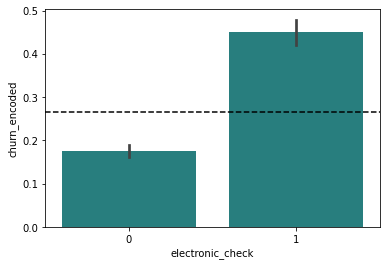

In [59]:
plt.figure(figsize=(6,4))
sns.barplot(x = 'electronic_check', y = 'churn_encoded', data=train, alpha=.9, color='teal')
plt.axhline(train['churn_encoded'].mean(), ls='--', color='black')
plt.show()

## Takeway: There is very high churn among those who use electronic checks for their payments.

### Hypothesis:

H0: Churn is not dependent on electronic check payment type.

H1: Churn is dependent on electronic check payment type.

In [33]:
observed3 = pd.crosstab(train.electronic_check, train.churn)

# scipy function calculates values based on the crosstab created
chi2, p, degf, expected = chi2_contingency(observed3)

print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

if p < alpha:
    print('\nP is less than alpha. We reject the null hypothesis.')

chi^2 = 334.9798
p     = 0.0000

P is less than alpha. We reject the null hypothesis.


### Therefore, using electronic checks for payments is associated with churn.

# Question: Is churn associated with those who don't receive tech support?

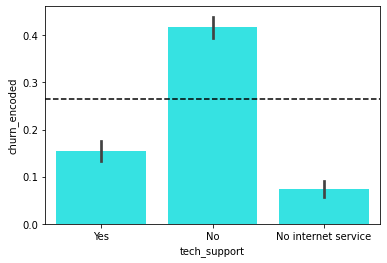

In [28]:
plt.figure(figsize=(6,4))
sns.barplot(x = 'tech_support', y = 'churn_encoded', data=train, alpha=.9, color='cyan')
plt.axhline(train['churn_encoded'].mean(), ls='--', color='black')
plt.show()

## Takeway: There is very high churn among those who don't receive tech_support.

### Hypothesis:

H0: Churn is not dependent on if a customer receives tech support.

H1: Churn is dependent on if a customer receives tech support.

In [34]:
observed8 = pd.crosstab(train.tech_support, train.churn)

# scipy function calculates values based on the crosstab created
chi2, p, degf, expected = chi2_contingency(observed8)

print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

if p < alpha:
    print('\nP is less than alpha. We reject the null hypothesis.')

chi^2 = 460.8719
p     = 0.0000

P is less than alpha. We reject the null hypothesis.


### Therefore, those who don't receive technical support are associated with churn.

# Modeling

The features tested all rejected the null, so they will be the focal points in the models. All other columns will be excluded to produce more precise results.

## What I am looking for:

I will be focusing mainly on the accuracy percentage for the models I move into the validation step of testing. False Negatives are most important in this situation, as predicting a customer won't churn and then they do would be the most important data to have missed out on.

#### The possible outcomes:

TP = Predict that a customer will churn and they do

TN = Predict that a customer will not churn and they do not

FP = Predict that a customer will churn but they do not

FN = Predict that a customer will not churn but they do

In [37]:
# All columns that need to be dropped
columns_to_drop = ['partner', 'gender', 'dependents', 'phone_service', 'multiple_lines', 'online_security', 'online_backup', 'device_protection', 
                   
                  'tech_support', 'streaming_tv', 'streaming_movies', 'paperless_billing', 'churn', 'churn_encoded', 'contract_type', 'internet_service_type', 'payment_type',
                  ]

In [41]:
# Create the object
X_train = train.drop(columns = columns_to_drop)
y_train = train.churn_encoded

X_validate = validate.drop(columns = columns_to_drop)
y_validate = validate.churn_encoded

X_test = test.drop(columns = columns_to_drop)
y_test = test.churn_encoded

# Setting Up The Baseline

The baseline is the simplest possible prediction and usually the most common. 

In [42]:
baseline = train.churn_encoded.mode()
baseline

0    0
dtype: int64

In [43]:
baseline = 0
baseline_accuracy = (train.churn_encoded == baseline).mean()
print(f'Baseline Accuracy: {baseline_accuracy:.2%}')

Baseline Accuracy: 73.43%


# Decision Tree

In [44]:
df = DecisionTreeClassifier(max_depth=6, random_state=123)

df.fit(X_train, y_train)

y_pred = df.predict(X_train)
y_pred_proba = df.predict_proba(X_train)

#evaluate metrics
print('Accuracy of model with all features in train set:', df.score(X_train, y_train))
print('\nThe confusion matrix:\n',confusion_matrix(y_train, y_pred))
print('\nClassification report:\n',classification_report(y_train, y_pred))

Accuracy of model with all features in train set: 0.8173736347472695

The confusion matrix:
 [[2625  266]
 [ 453  593]]

Classification report:
               precision    recall  f1-score   support

           0       0.85      0.91      0.88      2891
           1       0.69      0.57      0.62      1046

    accuracy                           0.82      3937
   macro avg       0.77      0.74      0.75      3937
weighted avg       0.81      0.82      0.81      3937



# Random Forest

In [45]:
rf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=3,
                            n_estimators=100,
                            max_depth=4, 
                            random_state=123)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_train)
y_pred_proba = rf.predict_proba(X_train)
print('Accuracy of model with all features in train set:', rf.score(X_train, y_train))
print('\nThe confusion matrix:\n',confusion_matrix(y_train, y_pred))
print('\nClassification report:\n',classification_report(y_train, y_pred))

Accuracy of model with all features in train set: 0.8008636017272035

The confusion matrix:
 [[2719  172]
 [ 612  434]]

Classification report:
               precision    recall  f1-score   support

           0       0.82      0.94      0.87      2891
           1       0.72      0.41      0.53      1046

    accuracy                           0.80      3937
   macro avg       0.77      0.68      0.70      3937
weighted avg       0.79      0.80      0.78      3937



# KNN

In [47]:
knn = KNeighborsClassifier(n_neighbors=15)

knn.fit(X_train, y_train)

y_pred = knn.predict(X_train)
y_pred_proba = knn.predict_proba(X_train)
print('Accuracy of model with all features in train set:', knn.score(X_train, y_train))
print('\nThe confusion matrix:\n',confusion_matrix(y_train, y_pred))
print('\nClassification report:\n',classification_report(y_train, y_pred))

Accuracy of model with all features in train set: 0.8036576073152146

The confusion matrix:
 [[2719  172]
 [ 601  445]]

Classification report:
               precision    recall  f1-score   support

           0       0.82      0.94      0.88      2891
           1       0.72      0.43      0.54      1046

    accuracy                           0.80      3937
   macro avg       0.77      0.68      0.71      3937
weighted avg       0.79      0.80      0.79      3937



# Logistic Regression

In [48]:
lr = LogisticRegression(C=1, class_weight={0:1, 1:99}, random_state=123, intercept_scaling=1, solver='lbfgs')

lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)
y_pred_proba = lr.predict_proba(X_train)

print('Accuracy of model with all features in train set:', lr.score(X_train, y_train))
print('\nThe confusion matrix:\n',confusion_matrix(y_train, y_pred))
print('\nClassification report:\n',classification_report(y_train, y_pred))

Accuracy of model with all features in train set: 0.33985267970535943

The confusion matrix:
 [[ 294 2597]
 [   2 1044]]

Classification report:
               precision    recall  f1-score   support

           0       0.99      0.10      0.18      2891
           1       0.29      1.00      0.45      1046

    accuracy                           0.34      3937
   macro avg       0.64      0.55      0.31      3937
weighted avg       0.81      0.34      0.25      3937



#### From this point, we need 3 models that did the best to move on. I decided to leave out the Logistic Regression, as it was by far the lowest in accuracy at 34%

# Validate

In [52]:
df = DecisionTreeClassifier(max_depth=6, random_state=123)

df.fit(X_train, y_train)

y_pred = df.predict(X_validate)
y_pred_proba = df.predict_proba(X_validate)

print('Accuracy of model within validate set:', df.score(X_validate, y_validate))
print('\nThe confusion matrix:\n',confusion_matrix(y_validate, y_pred))
print('\nClassification report:\n',classification_report(y_validate, y_pred))

Accuracy of model within validate set: 0.7790284360189573

The confusion matrix:
 [[1067  172]
 [ 201  248]]

Classification report:
               precision    recall  f1-score   support

           0       0.84      0.86      0.85      1239
           1       0.59      0.55      0.57       449

    accuracy                           0.78      1688
   macro avg       0.72      0.71      0.71      1688
weighted avg       0.77      0.78      0.78      1688



In [53]:
rf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=3,
                            n_estimators=100,
                            max_depth=4, 
                            random_state=123)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_validate)
y_pred_proba = rf.predict_proba(X_validate)

print('Accuracy of model within validate set:', rf.score(X_validate, y_validate))
print('\nThe confusion matrix:\n',confusion_matrix(y_validate, y_pred))
print('\nClassification report:\n',classification_report(y_validate, y_pred))

Accuracy of model within validate set: 0.7837677725118484

The confusion matrix:
 [[1146   93]
 [ 272  177]]

Classification report:
               precision    recall  f1-score   support

           0       0.81      0.92      0.86      1239
           1       0.66      0.39      0.49       449

    accuracy                           0.78      1688
   macro avg       0.73      0.66      0.68      1688
weighted avg       0.77      0.78      0.76      1688



In [54]:
knn = KNeighborsClassifier(n_neighbors=15)

knn.fit(X_train, y_train)

y_pred = knn.predict(X_validate)
y_pred_proba = knn.predict_proba(X_validate)

print('Accuracy of model within validate set:', knn.score(X_validate, y_validate))
print('\nThe confusion matrix:\n',confusion_matrix(y_validate, y_pred))
print('\nClassification report:\n',classification_report(y_validate, y_pred))

Accuracy of model within validate set: 0.7813981042654028

The confusion matrix:
 [[1133  106]
 [ 263  186]]

Classification report:
               precision    recall  f1-score   support

           0       0.81      0.91      0.86      1239
           1       0.64      0.41      0.50       449

    accuracy                           0.78      1688
   macro avg       0.72      0.66      0.68      1688
weighted avg       0.77      0.78      0.76      1688



#### When deciding what to use for the test, it came very close for my Random Forrest and KNN module, as they're accuracy fell very close to one another. Both came to 78% accuracy, so we needed to see where they did better in other places. I wanted to focus on prediction of False Negatives, as that would mean a customer would be predicted not to churn, but will, which I feel is important to keep track of. Based on that, I focused on their recall. So the decision came to using the KNN model, which beat Random Forrest with 41%, while Random Forrest was at 39%.

# Test

#### To recall, we are trying to see if our model can beat our baseline. 

In [57]:
baseline = 0
baseline_accuracy = (train.churn_encoded == baseline).mean()
print(f'Baseline Accuracy: {baseline_accuracy:.2%}')

Baseline Accuracy: 73.43%


In [58]:
knn = KNeighborsClassifier(n_neighbors=15)

knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)
y_pred_proba = knn.predict_proba(X_test)
print('Accuracy of model with all features in train set:', knn.score(X_test, y_test))
print('\nThe confusion matrix:\n',confusion_matrix(y_test, y_pred))
print('\nClassification report:\n',classification_report(y_test, y_pred))

Accuracy of model with all features in train set: 0.7882018479033405

The confusion matrix:
 [[950  83]
 [215 159]]

Classification report:
               precision    recall  f1-score   support

           0       0.82      0.92      0.86      1033
           1       0.66      0.43      0.52       374

    accuracy                           0.79      1407
   macro avg       0.74      0.67      0.69      1407
weighted avg       0.77      0.79      0.77      1407



## Baseline accuracy was 73.43%

## My developed KNN test 79%

# Conclusion:

### The factors that most affect churn can be solved in a number of ways. 
#### Senior Citizens:
1. Marketing to non senior citizens.
2. Create marketing to keep senior citizens, such as discounts or promotional deals for staying.

#### Fiber Optic:
1. There could be potential issues with the fiber optic service, so performing an investigation would be insightful.

#### Electronic Checks:
1. Create incentives to switch to different payment types to potentially reduce churn.

#### Tech Support:
1. Increase tech support coverage and make tech support resources more available

#### Next steps: explore the data to find more drivers of churn and use these to refine the model.